# Adversarial Attack on Mnist DataSet

Deep convolutional neural networks (CNN) are state of the art models for image classification and object detection. Nowaday, these models play a important role in many applications. It’s important to understand how they work and what their limitations are.

One known “limitation” of CNN is that they can be fooled to misclassify an image with high confidence by slightly perturbing the pixels. 

One of the useful application for adversarial images is that if we train our deep CNN classifier on them we can improve its accuracy on non-adversarial examples. In this challenge, we will go through the process of generating adversarial examples and also gain practical experience using Tensorflow.

In [3]:
# Dependencies for entire notebook here
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Loading the Data

In [4]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
# looking at training data
print('Training.images shape: ', mnist.train.images.shape)
print('Training.labels shape: ', mnist.train.labels.shape)
print('Shape of an image: ', mnist.train.images[0].shape)
print('Example label: ', mnist.train.labels[0])

Training.images shape:  (55000, 784)
Training.labels shape:  (55000, 10)
Shape of an image:  (784,)
Example label:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


# Visualizing some examples

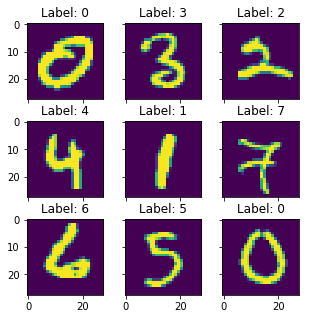

In [6]:
# looking at couple of examples
total_examples = mnist.train.images.shape[0]
no_samples = 9
indexes = np.random.choice(total_examples, size=no_samples, replace=False)
image_list = mnist.train.images[indexes,:]
image_list_labels = mnist.train.labels[indexes,:]

# borrowed some code from https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html
fig = plt.figure(1, (5., 5.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(3, 3),  
                 axes_pad=0.3,  
                 )

for i in range(len(image_list)):
    image = image_list[i].reshape(28,28)
    grid[i].imshow(image)
    grid[i].set_title('Label: {0}'.format(image_list_labels[i].argmax()))

plt.show()

In [7]:
# Some of Code for this cnn model is borrowed from tensorflow official site (https://github.com/tensorflow/docs/blob/master/site/en/tutorials/estimators/cnn.ipynb)

# Create placeholders nodes for images and label inputs
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])

    # Input Layer
    input_layer = tf.reshape(x, [-1, 28, 28, 1])

    # Convolutional Layer #1 32x5x5
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2; 64x5x5
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    keep_prob = tf.placeholder(tf.float32)
    dropout = tf.nn.dropout(dense, keep_prob)
    # dropout = tf.layers.dropout(
    #   inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    probabilities =  tf.nn.softmax(logits, name="softmax_tensor")

    #Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logits))

    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Setup to test accuracy of model
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Initializing Tensorflow

In [8]:
# Initilize all global variables
# tf.reset_default_graph()
sess = tf.InteractiveSession(graph=g)
sess.run(tf.global_variables_initializer())

# Training the Model

In [9]:
# Train model
# Run once to get the model to a good confidence level
for i in range(2000):
    batch = mnist.train.next_batch(100)
    if i%200 == 0:
        train_accuracy = accuracy.eval(session=sess, feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

    train_step.run(session=sess, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.4})

step 0, training accuracy 0.12
step 200, training accuracy 0.91
step 400, training accuracy 0.98
step 600, training accuracy 0.97
step 800, training accuracy 0.99
step 1000, training accuracy 0.95
step 1200, training accuracy 0.98
step 1400, training accuracy 0.98
step 1600, training accuracy 0.99
step 1800, training accuracy 1


# Testing the Model

In [10]:
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images[0:500], 
                                                  y_: mnist.test.labels[0:500], keep_prob: 1.0}))

test accuracy 0.984


In [11]:
def show_plots(image_list, adversarial=False):
    '''
    This functions plot the images for True image, partial derivitive and distorted 
    image as we will see in next section
    '''
    prob = probabilities.eval(feed_dict={x: image_list, keep_prob: 1.0})
    pred_list = np.zeros(len(image_list)).astype(int)
    pct_list = np.zeros(len(image_list)).astype(int)
    
    # Setting up image grid
    import math
    cols = 3
    rows = math.ceil(image_list.shape[0]/cols)
    fig = plt.figure(1, (24., 24.))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(rows, cols),  
                     axes_pad=0.5,  
                     )
    
    # Getting probabilities, images and populate the plot grid
    for i in range(len(prob)):
        pred_list[i] = np.argmax(prob[i])
        pct_list[i] = prob[i][pred_list[i]] * 100

        image = image_list[i].reshape(28,28)
        grid[i].imshow(image)
        
        grid[i].set_title('Label: {0} \nCertainty: {1}%' \
                          .format(pred_list[i], 
                                  pct_list[i]))
        
        if (adversarial) & (i % 3 == 1): 
            grid[i].set_title("Adversarial \nPartial Derivatives")
        
    plt.show()

# Fooling images for Model

This section explain the logic for creating adversarial image. Suppose that $L(x, y, m)$ is the data loss under model $m$, where we tell the network that the input $x$ should be classified as having label $y$. Given a starting image $x_0$, a desired label $y$, and a pretrained model $m$, we can create a fooling image $x_f$ by solving the following optimization problem:

$$x_f = \arg\min_x \left(L(x, y, m) + \frac\lambda2 \|x - x_0\|^2_2\right)$$

The term $\|x - x_0\|^2$ is $L_2$ regularization in image space which encourages the fooling image to look similar to the starting image, and the constant $\lambda$ is the strength of this regularization. We will use gradient descent to perform optimization under this model.

In [16]:
def make_fooling_image(x_image, y_label, step_size=0.5, reg=0.00002, confidence=0.5):
    """
    Perform optimization in image space to create an image that is similar to img
    but is classified as y_label by model.
    
    Inputs:
    - x_img: the starting point for the fooling image.
    - y_label: The desired label; one hot numpy array
    - reg: Regularization strength (in image space) for the fooling image. This
      is the parameter lambda in the equation above.
    - n_steps: The desired no of steps to create fooling image.
    - confidence: The desired confidence threshold for the fooling image.
    """
    original_image = x_image
    fooling_img = x_image.copy()
    probs_per_step = []
    
    # Calculate loss, derivative and create fooling image
    loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=logits)
    dX = tf.gradients(loss, x)
    
    while(True):
        # Calculating derivative and fooling image
        dx = sess.run(dX, {x: fooling_img, keep_prob: 1.0})
        dx_ = np.array(dx).reshape((1, 784))
        fooling_img -=step_size*(dx_+reg*(fooling_img-original_image))
        x_adv = fooling_img
        # get the confidence
        probs = np.array(probabilities.eval(feed_dict={x: fooling_img, keep_prob: 1.0}))
        label = np.argmax(probs, axis=1)[0]
        if label==np.argmax(y_label,axis=1)[0] and probs[0][label]>=confidence: break
        


    # Creating array of 3 images - orig, noise, fooling image
    x_image = np.reshape(x_adv, (1, 784))
    img_adv_list = original_image
    img_adv_list = np.append(img_adv_list, dx[0], axis=0)
    img_adv_list = np.append(img_adv_list, x_image, axis=0)
    return img_adv_list

In [17]:
print(len(mnist.test.labels))
print(mnist.test.labels[0:10].shape)

10000
(10, 10)


# Select few images to attack!

In [18]:
images_of_2s = np.nonzero(mnist.test.labels[0:10000][:,2])[0]
import sys
list_10_images = []
list_10_images_indexes = []
label_to_attack = 2
no_images = 10
# select 10 correctly classified images (requirement in the task)
for i in range(no_images):
    while (True):
        rand_index = np.random.randint(0, len(images_of_2s))
        if rand_index in list_10_images_indexes: continue
        # Getting the label and making sure the Label is correct
        image = mnist.test.images[images_of_2s[rand_index]]
        image = np.reshape(image, (1, 784))
        logits_ = np.array(logits.eval(feed_dict={x: image, keep_prob: 1.0}))
        label = np.argmax(logits_,1)[0]
        if label!=label_to_attack: continue
        else: 
            list_10_images.append(image)
            list_10_images_indexes.append(rand_index)
            break

# Attacking :)

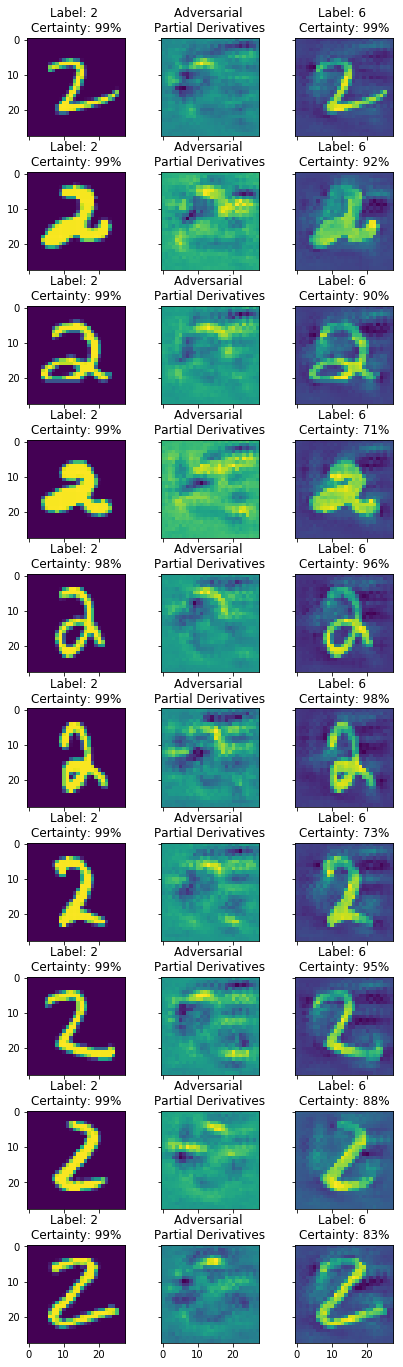

In [22]:
# Attack and Plot adversarial images

label_adv = np.array([0,0,0,0,0,0,1,0,0,0]) # one hot encoded, adversarial label 6
label_adv = np.reshape(label_adv, (1, 10))
for i, image in enumerate(list_10_images):
    list_ = make_fooling_image(image, label_adv, step_size=0.3, reg=0.25, confidence=0.5)
    if i==0:
        img_adv_list = list_
    else:
        img_adv_list = np.append(img_adv_list, list_, axis=0)
        

# ploting images and return probabilities
show_plots(img_adv_list, adversarial=True)


Results look okay, I think I could have done better job though!

# References
1) https://www.tensorflow.org/tutorials/

2) Goodfellow et al., 2014; EXPLAINING AND HARNESSING ADVERSARIAL EXAMPLES; https://arxiv.org/pdf/1412.6572.pdf
